In [1]:
import pyedflib
import mne
import numpy as np

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from os import listdir

from sklearn.metrics import precision_score , recall_score, confusion_matrix,  ConfusionMatrixDisplay
%matplotlib inline

### Reading signals

In [2]:
def ReadSignal(file_name): #move to utils

    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

    time = [1/f.samplefrequency(0) * i for i in range(len(sigbufs[0]))]

    annotations = f.readAnnotations()  

    shift = -annotations[0][0]

    if file_name != "data/record0.edf":
        assert np.isclose(shift, 0.91798)
    else:
        return sigbufs, f, time

    new_annot = [(annotations[0][i] + shift, annotations[1][i], annotations[2][i])  for i in range(len(annotations[0])) 
             if annotations[2][i] in ["new_label", "n"]]
    f.close()
    return sigbufs, new_annot, time

In [3]:
signals = []
events = []

for file_name in listdir("data"):
    if "golden" in file_name:
        sigbufs, event, time = ReadSignal("data/" + file_name)
        signals.append(sigbufs)
        events.append(event)
        

In [4]:
sigbufs, f, time = ReadSignal("data/record0.edf")

In [5]:
f.samplefrequency(0)

199.50274692224406

In [6]:
def Labeling(time, events_lst):
    labels = np.zeros_like(time)

    for events in events_lst:
        for event in events:
            start = np.array(time < event[0]).argmin()
            fin = np.array(time < event[0] + event[1]).argmin()
            labels[start:fin] =  1
    return labels
        

In [7]:
#labels = Labeling(time, events)
#np.save("data/new_labels", labels)
labels = np.load("data/new_labels.npy")

### Train and Test

Let's test 6000 - 6800 sec, using only 6/9 of record to increase balance of classess

In [8]:
TEST_TIME_START = 6000
TEST_TIME_END = 6800

In [9]:
ind = np.argmax(labels)

test_idx = (np.array(time) < TEST_TIME_START).argmin()
test_idx2 = (np.array(time)< TEST_TIME_END).argmin()

test_x = torch.FloatTensor(sigbufs[:, test_idx:test_idx2]).to("cuda")
test_labels = labels[test_idx:test_idx2]

new_testl = torch.zeros(2, len(test_labels))
new_testl = (torch.arange(2) == torch.LongTensor(test_labels)[:,None]).T
new_testl = new_testl.float().to('cuda')
test_labels = new_testl


train_x1 = torch.FloatTensor(sigbufs[:, ind-100:test_idx]).to('cuda')
train_x2 = torch.FloatTensor(sigbufs[:, test_idx2:]).to('cuda')

train_labels1 = labels[ind-100:test_idx]
new_tl1 = torch.zeros(2, len(train_labels1))
new_tl1 = (torch.arange(2) == torch.LongTensor(train_labels1)[:,None]).T
new_tl1 = new_tl1.float().to('cuda')
train_labels1 = new_tl1

train_labels2 = labels[test_idx2:]
new_tl2 = torch.zeros(2, len(train_labels2))
new_tl2 = (torch.arange(2) == torch.LongTensor(train_labels2)[:,None]).T
new_tl2 = new_tl2.float().to('cuda')
train_labels2 = new_tl2

In [10]:
(train_labels1[1].sum() + train_labels2[1].sum()) /(len(train_labels1[1]) + len(train_labels2[1]))

tensor(0.0472, device='cuda:0')

Let's test 4000 points in sample 15 and 13 batch size for it, for 100 it 190 and 16

In [11]:
RECEPTIVE_FIELD = 4000

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD):
    inout_seq = []
    L = x.shape[-1]
    for i in tqdm(range(0, L- rf, rf)):
        train_seq = x[:, i:i+rf]
        train_label = labels[:, i:i+rf]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

In [12]:
test_samples = CreateSamples(test_x, test_labels)
train_samples = CreateSamples(train_x1, train_labels1) + CreateSamples(train_x2, train_labels2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 68971.08it/s]


In [13]:
idxs = []
new_train_samples = []
c = 0
labels_sum = 0
for i in range(len(train_samples)): 
    if train_samples[i][1][1].max() == 1:
        c += 1
        idxs.append(i)
        new_train_samples.append(train_samples[i])
        labels_sum += train_samples[i][1][1].sum()

In [14]:
train_dataloader = DataLoader(train_samples, batch_size=15, shuffle=True, drop_last=True) # or train_samples for 4000 or new_train_samples for 100
test_dataloader = DataLoader(test_samples, batch_size=13, shuffle=False, drop_last=True)

In [15]:
for idx, (x, y) in enumerate(train_dataloader):
    print(x.shape)
    print(y.shape)    
    break

torch.Size([15, 20, 4000])
torch.Size([15, 2, 4000])


In [16]:
#!L
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        x = super(CausalConv1d, self).forward(x)
        return x[:, :, :-self.padding[0]]

    



class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle (e.g. if set 10, max dilation = 2^(10-1))
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size, num_out_channels):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])
        
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        
        self.up_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=256,
            kernel_size=1)
        self.conv_input = nn.Conv1d(
            in_channels=256,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_out_channels,
            kernel_size=1)

    def forward(self, x):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]
            c (FloatTensor): local condition features [B x L x C],
                where L = T // 300

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(self.up_input(x)) # equal to x = torch.matmul(x.transpose(1, 2), model.conv_input.weight.squeeze().transpose(0, 1)) + model.conv_input.bias and transpose(1, 2)
        

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)


            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))

        return x

In [17]:
#!L
WaveNet_model = WaveNet(
    num_channels=20,
    residual_channels=64,
    gate_channels=64,
    skip_channels=128,
    pre_channels=256,
    dilation_cycles=10,
    dilation_depth=12,
    condition_channels=80,
    hop_size=300, 
    num_out_channels=2)
WaveNet_model.to('cuda')

WaveNet(
  (up_input): Conv1d(20, 256, kernel_size=(1,), stride=(1,))
  (conv_input): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
  (blocks_conv_filter): ModuleList(
    (0): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    (3): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
    (4): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(16,), dilation=(16,))
    (5): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(32,), dilation=(32,))
    (6): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(64,), dilation=(64,))
    (7): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(128,), dilation=(128,))
    (8): CausalConv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(256,), dilation=(256,))
    (9): CausalConv1d(

In [18]:
# test_input4000 = torch.FloatTensor(np.ones((32, 20, 4000)))
# WaveNet_model(test_input4000).size()

let it be 100 -> 20 -> 4 -> 1

In [19]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in tqdm(enumerate(dataloader)):
        if is_training:
            optimizer.zero_grad()
      
        #print("x", x.shape)
        

        out = model(x)
        #print("y", y.shape)
        #print("out", out.shape)
        loss = criterion(out, y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

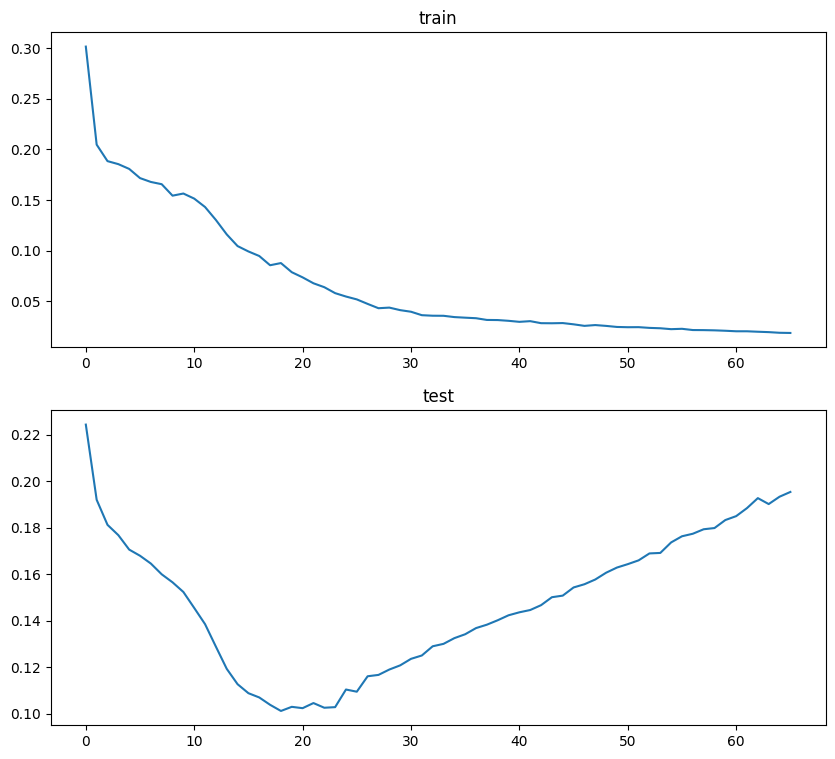

Epoch[66/175] | loss train:0.018793, test:0.195327


2it [00:00,  2.93it/s]


KeyboardInterrupt: 

In [20]:
# define optimizer and loss function

criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.FloatTensor([[0.3, 0.7]] * 4000).T.to("cuda"))
optimizer = optim.Adam(WaveNet_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor=0.5, min_lr=0.0001)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
best_loss = 10e9
# begin training

early_stop_count = 15
current_es = 0
for epoch in range(epochs): 
    
        
    loss_train = run_epoch(WaveNet_model, optimizer, criterion, train_dataloader, is_training=True)
    loss_val = run_epoch(WaveNet_model, optimizer, criterion, test_dataloader)
    scheduler.step(loss_val)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    if losses_test[-1] < best_loss:
        current_es = 0
        best_loss = losses_test[-1]
        torch.save(WaveNet_model.state_dict(), "./models/4000WaveNet4")
    else:
        current_es += 1
    #if current_es == early_stop_count:
        #break

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))

    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()


    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [21]:
WaveNet_model.load_state_dict(torch.load("./models/4000WaveNet4"))

<All keys matched successfully>

In [22]:
WaveNet_model.eval()
#model.cpu()
all_preds = []
for idx, (x, y) in enumerate(test_dataloader):
    x = x.float()
    #print("x", x.shape)

    out = WaveNet_model(x)
    m = nn.Softmax(dim=1)
    out = m(out)
    #print(out.size())
    #print("first", out[:, 0].max())
    #print("second", out[:, 1].max())
    
    preds = np.argmax(out.detach().cpu().numpy(), axis=1)
    all_preds.append(preds)

In [23]:
all_preds[0].shape

(13, 4000)

In [24]:
len(all_preds)

3

In [25]:
all_preds = np.array(all_preds).reshape(3 * 13 * 4000)#all_preds = np.array(all_preds).reshape(99 * 16 * 100)

In [27]:
#all_preds = np.load("predicts/4000conv1d_preds3.npy")

In [26]:
#np.save("predicts/4000WaveNet4_preds", all_preds)

### Some results 

#### Raw Labels

##### wavenet max layers

accuracy 0.9666346153846154
precision 0.6668459745382822
recall 0.5263232380413246


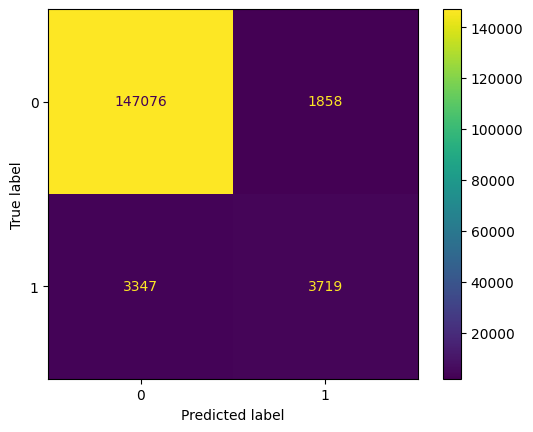

In [27]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### wavenet more layers

accuracy 0.9702564102564103
precision 0.6857580398162327
recall 0.6337390319841495


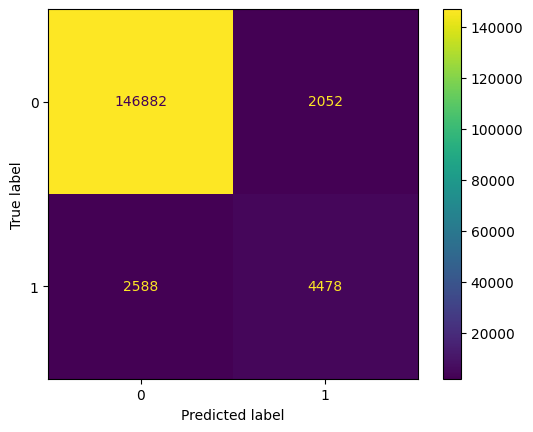

In [27]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### wavenet up layer


accuracy 0.9683076923076923
precision 0.6710738471460819
recall 0.5890178318709313


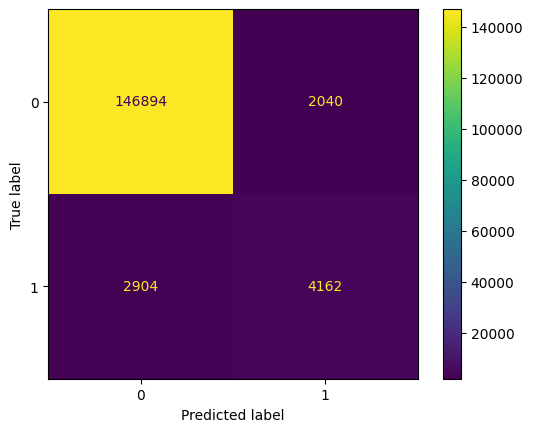

In [47]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### wavenet


In [25]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

accuracy 0.9669166666666666
precision 0.6643658326143227
recall 0.5448627228983867


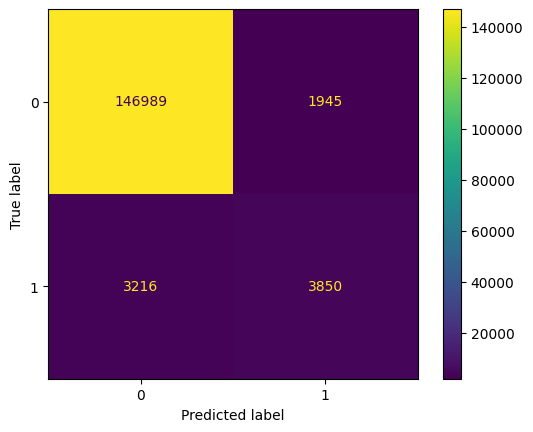

In [26]:
cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### less disbalanced 10%

In [28]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

accuracy 0.9720517676767677
precision 0.6792722547108512
recall 0.7273865850264403


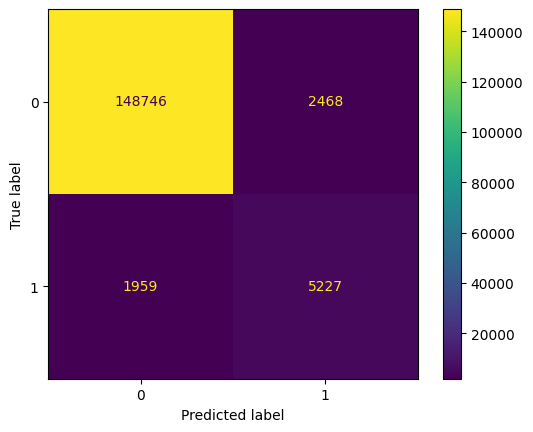

In [29]:
cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### all 100 0.4%

In [136]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

accuracy 0.9742613636363636
precision 0.7089100927294718
recall 0.7340662399109379


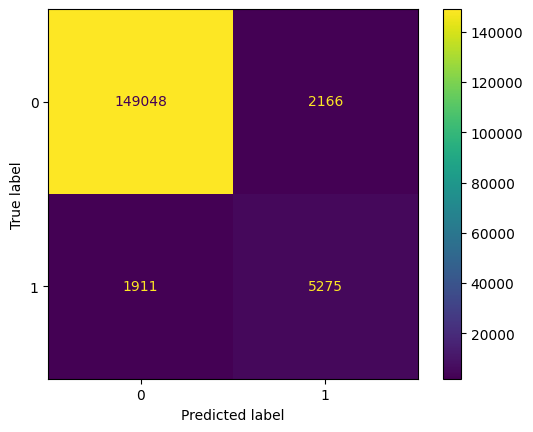

In [137]:
cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### 4000 new exp

In [30]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[1, :pred_len].detach().cpu().numpy()).sum() /  pred_len)
print("precision", precision_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))
print("recall", recall_score(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds))

accuracy 0.9750448717948718
precision 0.7320462191019453
recall 0.7083215397679027


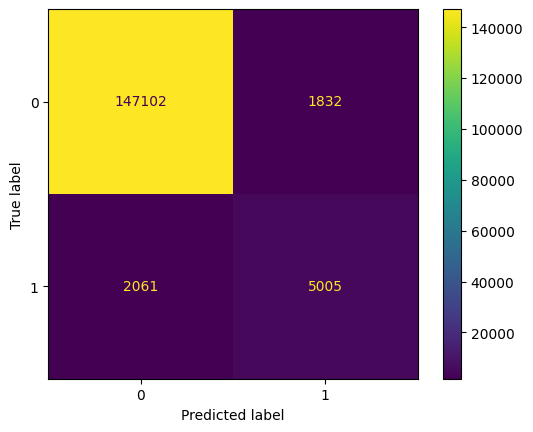

In [31]:
cm = confusion_matrix(test_labels[1, :pred_len].detach().cpu().numpy(), all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

##### 4000

In [23]:
pred_len = len(all_preds)
print("accuracy", (all_preds == test_labels[:pred_len]).sum() /  pred_len)
print("precision", precision_score(test_labels[:pred_len], all_preds))
print("recall", recall_score(test_labels[:pred_len], all_preds))

accuracy 0.9748910256410256
precision 0.7211065861536301
recall 0.7267195018397962


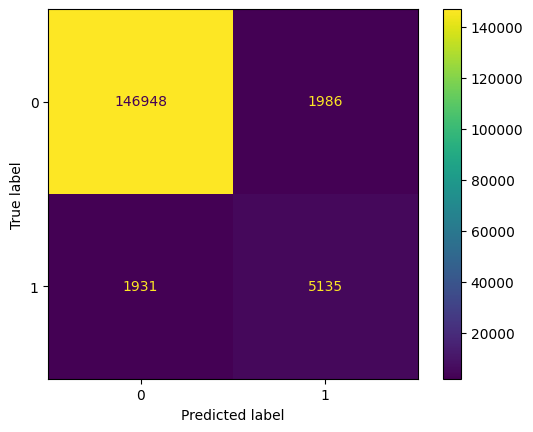

In [24]:
cm = confusion_matrix(test_labels[:pred_len], all_preds)
cm_display = ConfusionMatrixDisplay(cm).plot()

#### EpiSpike

In [28]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    while i < len(pred_labels):
        while true_labels[i] == 1:
            is_true_flag = 1
            if pred_labels[i] == 1:
                is_pred_flag = 1
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN              

##### WaveNet max layers

precision 0.5868263473053892
recall 0.8132780082987552


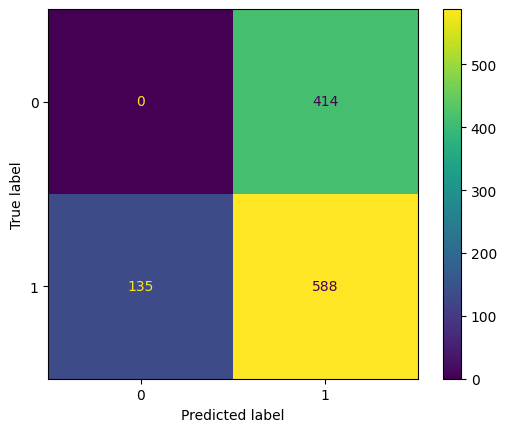

In [29]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

##### wavenet more layers

precision 0.5483870967741935
recall 0.8934993084370678


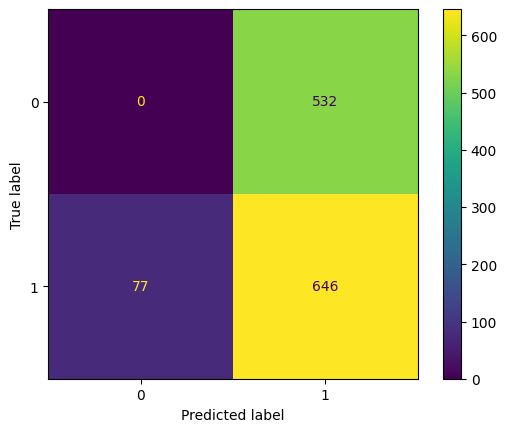

In [29]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

##### wavenet + up_layer

precision 0.5805243445692884
recall 0.8575380359612724


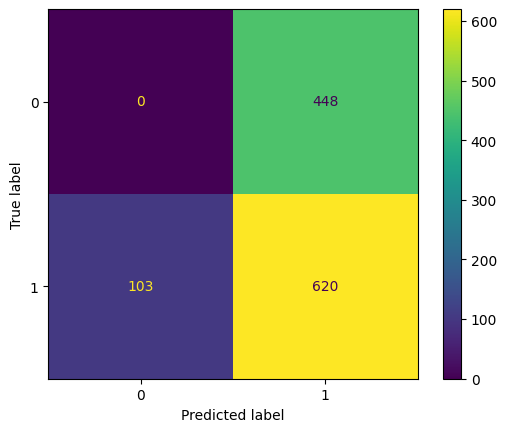

In [49]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

##### wavenet

precision 0.5214776632302406
recall 0.8395573997233748


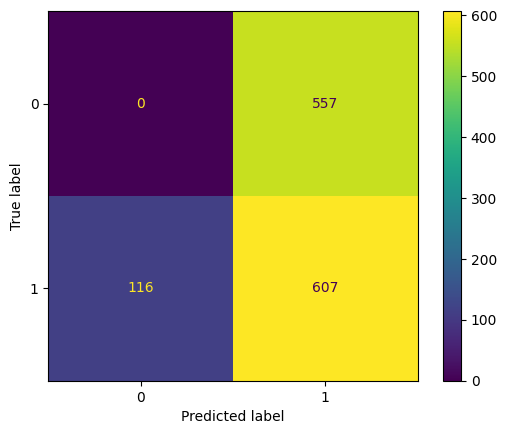

In [28]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

##### less disbalanced 10%

In [31]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())

In [32]:
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))

precision 0.6724137931034483
recall 0.8995929443690638


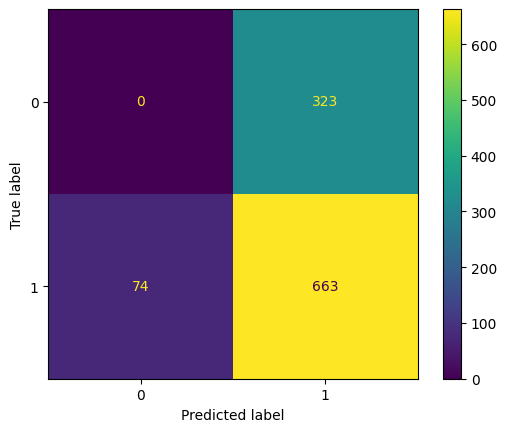

In [33]:
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

##### 100 0.4%

In [139]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())

In [140]:
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))

precision 0.7273768613974799
recall 0.8616010854816825


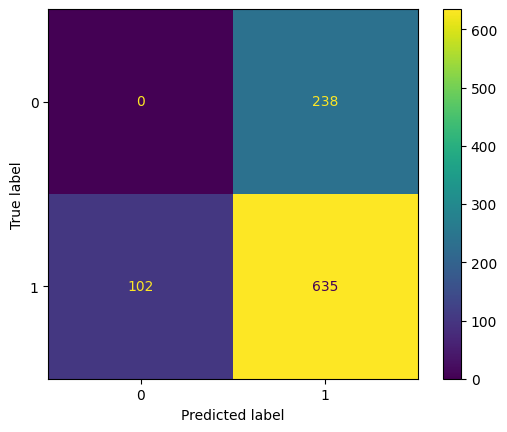

In [141]:
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

Для сотни по нахождениям пиков получилось по метрике лучше, но она не учитывала толщину пересечения, но не факт, что я хорошо пометил толщину, но для определения индекса это важная особенность

##### new 4000 exp

In [32]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[1, :pred_len].detach().cpu().numpy())

In [33]:
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))

precision 0.7228260869565217
recall 0.9197786998616874


In [2]:
0.7228260869565217 * 0.9197786998616874 / (0.7228260869565217 + 0.9197786998616874) * 2

0.8094948265368227

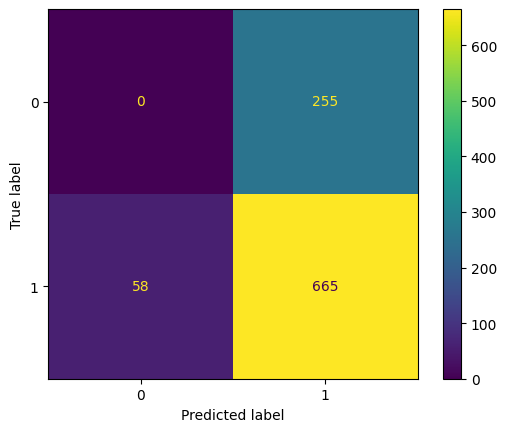

In [34]:
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

##### 4000

In [37]:
TP, FP, FN = CollectingTPFPFN(all_preds, test_labels[:pred_len])

In [39]:
print("precision",TP / (TP + FP))
print("recall", TP / (TP + FN))

precision 0.7079741379310345
recall 0.9087136929460581


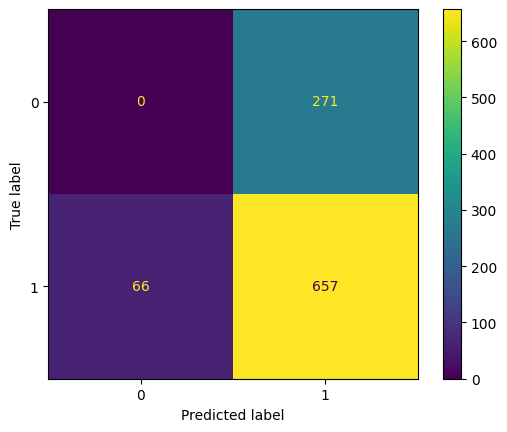

In [38]:
cm = np.array([[0, FP], [FN, TP]])
cm_display = ConfusionMatrixDisplay(cm).plot()

In [30]:
correct_idxs = []
false_negative = []
false_positive = []

for i in range(pred_len):
    if all_preds[i] == 1 and test_labels[:pred_len][i] == 1:
        correct_idxs.append(i)
    if all_preds[i] == 1 and test_labels[:pred_len][i] == 0:
        false_positive.append(i)
    if all_preds[i] == 0 and test_labels[:pred_len][i] == 1:
        false_negative.append(i)

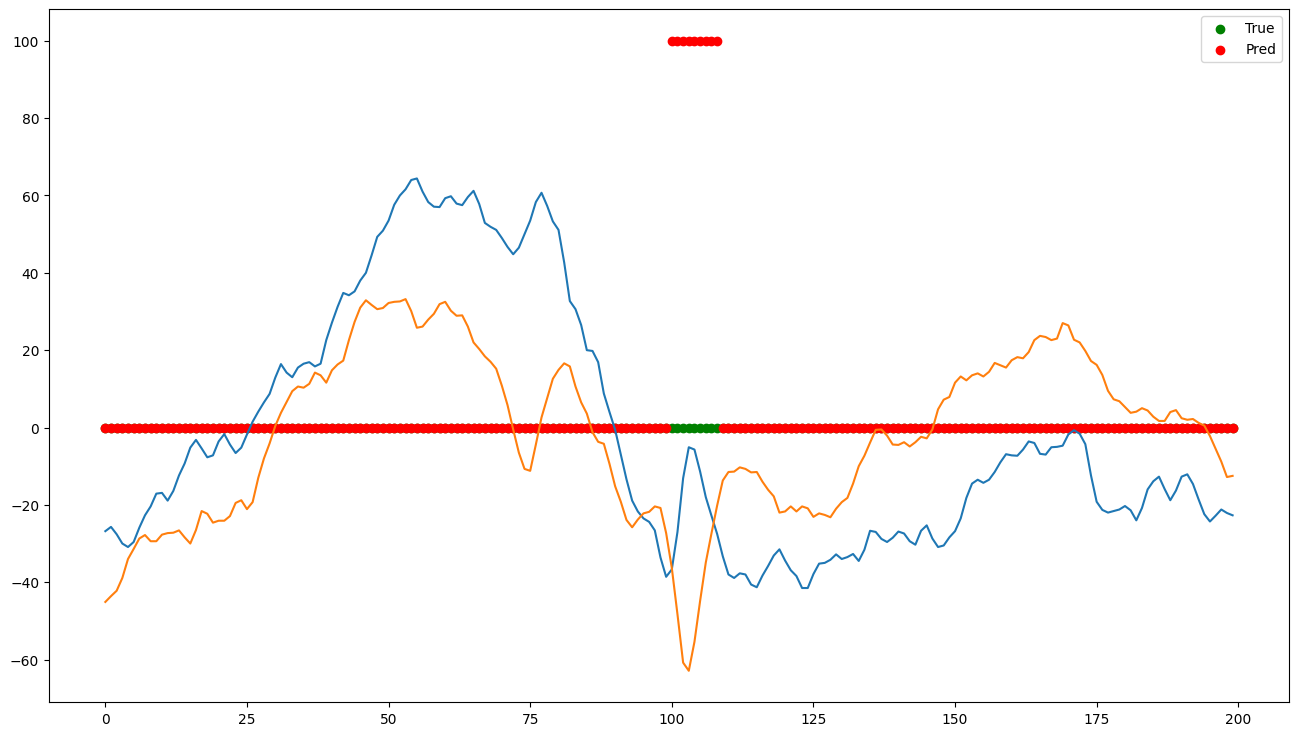

In [34]:
range_start = false_positive[0] - 100
range_end = false_positive[0] + 100

plt.figure(figsize=(16, 9))
plt.plot(test_x[2, :pred_len][range_start:range_end])
plt.plot(test_x[4, :pred_len][range_start:range_end])

plt.scatter(x=list(range(range_end - range_start)), y=test_labels[:pred_len][range_start:range_end] * -100, color="green", label="True")
plt.scatter(x=list(range(range_end - range_start)), y=all_preds[range_start:range_end] * 100, color="red", label="Pred")
plt.legend()

### EDF wtire

In [29]:
def CreateAnnotation(time_start, labels, freq):  # можно связать с прошлой анотацией, попробовать p concatenate
    freq = 1/freq
    i = 0
    label_starts = [time_start]
    label_lens = [-1]
    desc = ["StartPredictionTime"]
    while i < len(labels):
        if labels[i] == 1:
            desc.append("ModelPrediction")
            label_starts.append(time_start + i*freq)
            cur_start = i
            while labels[i] == 1:
                i += 1
            label_lens.append((i - cur_start) * freq)
        i += 1
    label_starts += [time_start + i*freq]
    label_lens += [-1]
    desc += ["EndPredictionTime"]

    return np.array(label_starts), np.array(label_lens), np.array(desc)

In [30]:
TEST_TIME_START = 6000

In [31]:
freq = f.samplefrequency(0)
preds_annotations = CreateAnnotation(TEST_TIME_START, all_preds, freq)


In [32]:
f.close()

In [33]:
data = mne.io.read_raw_edf("data/record0-Copy1.edf")
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/record0-Copy1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_723216/659960048.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/record0-Copy1.edf")


In [34]:
dur_max = preds_annotations[1].max()
preds_annotations = list(preds_annotations)
preds_annotations[1] = np.clip(preds_annotations[1], a_min=0, a_max = dur_max)
preds_annotations[1].min()

0.0

In [35]:
old_annot = np.array([[data.annotations[i]["onset"], data.annotations[i]["duration"], data.annotations[i]["description"]] 
                      for i in range(len(data.annotations))])
full_annot = np.concatenate([np.array(preds_annotations), old_annot.T], axis=1)
annotations = mne.Annotations(full_annot[0], full_annot[1], full_annot[2])

In [36]:
data.set_annotations(annotations)
data.annotations

<Annotations | 4288 segments: * (2953), EndPredictionTime (1), ...>

In [37]:
data.export("predicts/WaveNetPreds4000record0.edf", overwrite=True)

Reading 0 ... 1551204  =      0.000 ...  7775.352 secs...


/tmp/ipykernel_723216/4132297296.py:1: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export("predicts/WaveNetPreds4000record0.edf", overwrite=True)
